## **Simulating Backtest of crypto trading algorithms using stored trend data and generating close data**


## Generating close data

Importing libraries

In [1]:
from sqlalchemy import create_engine
from binance.client import Client
import pymysql
import pandas as pd
import datetime
import numpy as np
import pickle
import random

Connecting to Database

In [2]:
api_key = 'ihvXWbHvvDrYuroIJOS9ANW6X7tv5OQSYibLLloKyIGui0w93Q5yUJOBZclnNL5D'
api_secret = 'uzmKBJ3lmVS4TsTl2AOHVJOYTFfLM5qrg00vAqUyTYbSjiy7BDPlTpaq2Oy7qdo2'
client = Client(api_key, api_secret)

db_data = 'mysql+mysqldb://' + 'admin' + ':' + '0323A8E3DB' + '@' + 'coin-database-1-instance-1.c9hqcydvu19f.us-east-1.rds.amazonaws.com' + ':3306/' + 'crypto_db' + '?charset=utf8mb4'
engine = create_engine(db_data)

Function to fetch coin data

In [3]:
def getminutedata(symbol, start, end):
    frame = pd.DataFrame(client.get_historical_klines(symbol, Client.KLINE_INTERVAL_15MINUTE, start, end))
    frame = frame.iloc[:,:6]                                                    
    frame.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    frame = frame.set_index('date')
    frame.index = pd.to_datetime(frame.index, unit= 'ms')
    frame = frame.astype(float)
    return frame.reset_index()

Fetching crypto_table and id_list from database

In [4]:
cryptoString = 'SELECT * FROM crypto'
crypto_table = pd.read_sql_query(cryptoString, engine)
full_id_list = crypto_table.id.astype(int).tolist()

Find most recent date in price table

In [11]:
dateString = "SELECT MAX(date) FROM crypto_price"
recentDate = pd.read_sql_query(dateString, engine)
resentTimestamp = recentDate.at[0, 'MAX(date)']

In [24]:
str(resentTimestamp + datetime.timedelta(minutes = 15))


'2022-03-17 21:15:00'

In [ ]:
datetime.datetime.now().strftime("%Y-%m-%D %H:%M:%S")

In [23]:
getminutedata(crypto_table.loc[crypto_table['id'] == id]['ticker'].values[0], str(resentTimestamp), '2022-03-17 21:30:00')

,date,open,high,low,close,volume
0,2022-03-17 21:00:00,0.7469,0.7488,0.7460,0.7469,148541.0
1,2022-03-17 21:15:00,0.7468,0.7502,0.7465,0.7492,347029.0
2,2022-03-17 21:30:00,0.7492,0.7499,0.7472,0.7481,118777.0


Update Crypto Price table to current date

In [ ]:
start_string = "2022-03-11 12:00:00"
end_string = "2022-03-11 13:45:00"

for id in full_id_list:
    df = getminutedata(crypto_table.loc[crypto_table['id'] == id]['ticker'].values[0], start_string, end_string)
    df['crypto_id'] = id
    df.to_sql("crypto_price", engine, if_exists="append", index=False)

In [3]:
#download data for sim
settings = pd.read_pickle("./id_list_20_12_2.pkl")
settings = settings.set_index('id')
settings.index = settings.index.astype(int)
#settings = settings.drop([226, 227])#, 243, 266, 227, 189, 78, 211
id_list = settings.index.tolist()

#id = [149]
indicator = []
close = []
for artifact_id in id_list:
    closeString = 'SELECT date, close FROM artifact_price WHERE artifact_id="{}"'.format(artifact_id)
    hypeString = 'SELECT date, hype FROM artifact_trend WHERE artifact_id="{}"'.format(artifact_id)
    
    value = pd.read_sql_query(closeString, con)
    trend = pd.read_sql_query(hypeString, con)
    
    if value.empty or trend.empty:
        print(str(artifact_id) + "failed due to empty")
        continue
    
    value['date'] = pd.to_datetime(value['date'])
    trend['date'] = pd.to_datetime(trend['date'])

    value = value.set_index('date')
    trend = trend.set_index('date')
    
    half_way = '2021-08-28 21:00:00'
    try:
        value = value[trend.index[0]:]
        trend = trend[value.index[0]:]
        value = value[half_way:]
        trend = trend[half_way:]
    except:
        print(str(artifact_id) + "failed due to 28-08")
        continue

    trend[f"{artifact_id}"] = trend.iloc[:, 0].diff(periods=1).values
    trend = trend.drop(['hype'], axis=1)
    indicator.append(trend)

    value = value.rename(columns={"close": f"{artifact_id}"})
    close.append(value)

con.close()

In [4]:
#indicators = pd.concat(indicator, axis=1)
#closes = pd.concat(close, axis=1)
#pd.set_option('display.max_rows', 133481)
#indicator = indicator.join(diff) 

# for x, df in enumerate(indicator):
#     print(indicator[x].iloc[1400])
# #indicators = pd.DataFrame()
for x, df in enumerate(indicator):
    df = df[~df.index.duplicated(keep='last')]
    if x == 0:
        indicators = df
    else:
        indicators = indicators.join(df)
        #print(len(df))
        #print(len(indicators))
#len(indicator[0])
#len(indicator[0].join(indicator[20]))
#len(indicators)
#display(indicators)
#display(indicator[19])
for x, df in enumerate(close):
    df = df[~df.index.duplicated(keep='last')]
    if x == 0:
        closes = df
    else:
        closes = closes.join(df)

In [5]:
indicators

,9,19,23,36,39,45,50,56,57,59,...,225,227,230,231,233,242,243,249,266,274
date,,,,,,,,,,,,,,,,,,,,,
2021-10-01 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-01 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-01 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-02 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-28 17:00:00,0.0,-20.0,-4.0,1.0,-19.0,0.0,-13.0,13.0,-7.0,9.0,...,-37.0,-11.0,-4.0,-17.0,4.0,0.0,-6.0,11.0,-14.0,1.0
2021-11-28 18:00:00,28.0,0.0,6.0,-19.0,21.0,0.0,-1.0,-2.0,14.0,-7.0,...,26.0,-5.0,-3.0,11.0,-35.0,-12.0,-8.0,1.0,1.0,8.0
2021-11-28 19:00:00,-26.0,-7.0,-8.0,62.0,-16.0,41.0,-9.0,-14.0,-10.0,11.0,...,59.0,11.0,11.0,2.0,27.0,27.0,7.0,38.0,1.0,-3.0


In [70]:
upward = closes.diff(periods=8)

upward.index = pd.to_datetime(upward.index)
closes.index = pd.to_datetime(closes.index)
indicators.index = pd.to_datetime(indicators.index)



minbuy = settings['minbuy'].transpose()
minsell = settings['minsell'].transpose()
minbuy.index.name = None
minsell.index.name = None

maxholds = 3
holding = [False] * (len(id_list))
trades = [[],[],[],[]]

tradedata = []
buyPrice  = [0] * (len(id_list))
sellPrice = [0] * (len(id_list))
tradeBuy  = [0] * (len(id_list))
tradeSell = [0] * (len(id_list))
buyTime   = [0] * (len(id_list))
sellTime  = [0] * (len(id_list))
holdingHistory = []


for index, row in indicators.iterrows():
    #print(holding)
    holdingHistory.append(holding.copy())
    indicate_buy = row.reset_index(drop=True)>minbuy.reset_index(drop=True) 
    inc = (upward.loc[index] >= 0).reset_index(drop=True)
    buy = np.logical_and( np.logical_and(indicate_buy, inc), np.logical_not(holding) )
    buy_ids = [id_list[i] for i in [i for i, x in enumerate(buy) if x]]
    random.shuffle(buy_ids)
    if ((sum(holding) < maxholds) and buy_ids):
        for id in reversed(buy_ids):
            if (sum(holding) < maxholds):
                key = id_list.index(id)
                
                buyPrice[key] = closes.loc[index,str(id)]
                buyTime[key] = index
                holding[key] = True
            else:
                continue

    #indicate_sell = row.reset_index(drop=True)<minsell.reset_index(drop=True)
    cond1 = row.reset_index(drop=True)<minsell.reset_index(drop=True)
    cond2 = (closes.loc[index].reset_index(drop=True) < [x * 0.8 for x in buyPrice])
    #cond3 = (closes.loc[index].reset_index(drop=True) > [x * 1.2 for x in buyPrice])

    indicate_sell = [a or b for a, b in zip(cond1, cond2)]

    sell = np.logical_and(indicate_sell, holding)
    sell_ids = [id_list[i] for i in [i for i, x in enumerate(sell) if x]]

    if (sell_ids):
        for id in sell_ids:
            key = id_list.index(id)
            sellPrice[key] = closes.loc[index,str(id)]
            sellTime[key] = index
            #print([id, buyTime[key], sellTime[key], buyPrice[key], sellPrice[key], (sellPrice[key]/buyPrice[key]) ])
            tradedata.append([id, buyTime[key], sellTime[key], buyPrice[key], sellPrice[key], (sellPrice[key]/buyPrice[key]) ])
            holding[key] = False


    # if (holding == True and nHype[row][3] == True):
    #     sellprice = nHype[row][4]
    #     tradeBuy.append(buyprice)
    #     tradeSell.append(sellprice)
    #     sellTime.append(nHype[row][0])
    #     holding = False
tradedata = np.array(tradedata)
scaled = ((tradedata[:,5] - 1) * 1/maxholds) + 1

scaled.prod()

15.026167686346767

In [76]:

#(scaled.mean())
#(tradedata[:,5].prod())/maxholds
#np.mean(tradedata, axis=2)
#buyPrice
#[] * (len(id_list))
#display(closes.head())
#closes.loc[index,str(id)]
# upward = closes.diff(periods=8)
# upward.iloc[100] >= 0

tradedata

  




   

 

array([[230, Timestamp('2021-10-04 18:00:00'),
        Timestamp('2021-10-04 19:00:00'), 0.02963, 0.02963, 1.0],
       [23, Timestamp('2021-10-04 18:00:00'),
        Timestamp('2021-10-04 21:00:00'), 2.303, 2.244,
        0.9743812418584457],
       [266, Timestamp('2021-10-04 18:00:00'),
        Timestamp('2021-10-04 23:00:00'), 16.99, 16.87,
        0.9929370217775163],
       ...,
       [193, Timestamp('2021-11-28 14:00:00'),
        Timestamp('2021-11-28 15:00:00'), 3.689, 3.654,
        0.9905123339658444],
       [249, Timestamp('2021-11-28 15:00:00'),
        Timestamp('2021-11-28 16:00:00'), 0.4311, 0.4294,
        0.9960565993968917],
       [165, Timestamp('2021-11-28 16:00:00'),
        Timestamp('2021-11-28 20:00:00'), 0.09297, 0.09583,
        1.0307626115951383]], dtype=object)

In [9]:
from tabulate import tabulate
pd.set_option('display.max_rows', 2000)
#display(pd.DataFrame(tradedata, columns=['id', 'buy date', 'sell date', 'buy value', 'sell value', 'gain']).sort_values(by = 'gain'))

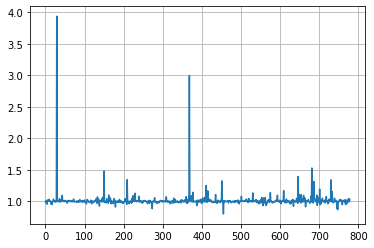

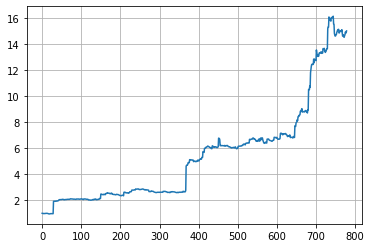

In [84]:
import matplotlib.pyplot as plt
tradedata = np.array(tradedata)
negatives = [i for i in tradedata[:,5] if i<1]
positives = [i for i in tradedata[:,5] if i>1]
plt.plot(tradedata[:,5])
plt.grid(True)
plt.show()
plt.plot(scaled.cumprod())
plt.grid(True)
plt.show()

In [86]:
#np.array(tradedata)
id_list[22]
#tradedata[:,5].cumprod()

155

In [71]:
holdingHistory = np.array(holdingHistory)

for x in range(len(id_list)):
    print(holdingHistory[:,x].sum(), end=', ')

63, 29, 78, 30, 51, 105, 168, 91, 43, 8, 58, 49, 122, 55, 34, 32, 12, 23, 30, 128, 57, 396, 520, 50, 159, 2, 19, 126, 39, 40, 19, 5, 40, 24, 74, 43, 36, 38, 56, 6, 94, 49, 